# Análise de Subestruturas

Essa análise faz parte de um projeto com o professor Patrick Steel.
Projeto auxiliado pelo @arturcgs.

A ideia inicial é clusterizar as moléculas e achar estruturas máximas em comum, fazendo também uma análise mais simples de propriedades farmacocinéticas (ADME).
Começamos com o padrâo: importando as bibliotecas necessárias

In [1]:
#importando bibliotecas
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory
from teachopencadd.utils import seed_everything

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Descriptors, Draw, PandasTools
from rdkit.ML.Cluster import Butina

from matplotlib.lines  import Line2D
import matplotlib.patches as mpatches

In [2]:
#definindo espaco de trabalho
here = Path(_dh[-1])
DATA = here/"DATA" #criando novo diretorio para salvar os resultados caso necessario

In [3]:
URL = 'https://raw.githubusercontent.com/arturcgs/steel_project/main/data_exploration/VEHICLe.csv'
molecules = pd.read_csv(URL)

molecules = molecules.rename(columns = {'Smiles': 'smiles'})
                     
print(f'The databank has {molecules.shape[0]} molecules')
molecules.head()

The databank has 24867 molecules


,Regid,smiles,Training_dataset_hits,Beilstein_hits_June_08,Pgood,Tautomer_cluster
0,S1,c1cc[nH]c1,81848,NaN,0.99,NaN
1,S10,c1c[nH]nn1,7925,NaN,0.98,2.0
2,S100,O=C1C=CSC=C1,7,375.0,0.92,NaN
3,S1000,O=C1OC(=O)c2sccc2S1,0,0.0,0.86,NaN
4,S10000,O=C1N=NN2C=CC=NN2C1=O,0,0.0,0.00,NaN


O banco de dados fornecido pelo professor Steel possui mais de 24000 estruturas. A matriz fornecida possui algumas variaveis que ainda não compreendemos, i.e (Pgood? Tauto? Training_dataset_hits?). Para nossa análise inicial, usaremos apenas o índice (e Regid) bem como os smiles.

In [4]:
molecules = molecules[["Regid","smiles"]] #selecionamos apenas as duas variaveis

molecules.dropna(axis=0, how = "any", inplace = True) #dropamos as linhas sem estruturas (aparentemente nenhuma)

molecules.drop_duplicates("Regid", keep="first", inplace = True) #dropamos os smiles repetidos

molecules.reset_index(drop = True, inplace = True) #resetamos o índice (isso é realmente necessario @arturcgs?)

print(f'O banco de dados possui {molecules.shape[0]} molecules')
molecules.head()

O banco de dados possui 24867 molecules


,Regid,smiles
0,S1,c1cc[nH]c1
1,S10,c1c[nH]nn1
2,S100,O=C1C=CSC=C1
3,S1000,O=C1OC(=O)c2sccc2S1
4,S10000,O=C1N=NN2C=CC=NN2C1=O


,Regid,smiles,ROMol
0,S1,c1cc[nH]c1,
1,S10,c1c[nH]nn1,
2,S100,O=C1C=CSC=C1,
3,S1000,O=C1OC(=O)c2sccc2S1,
4,S10000,O=C1N=NN2C=CC=NN2C1=O,
...,...,...,...
24862,S9995,N1N=NON2N=CC=CN12,
24863,S9996,N1N=NON2C=CC=NN12,
24864,S9997,N1N=NSN2N=CC=CN12,
24865,S9998,N1N=NSN2C=CC=NN12,

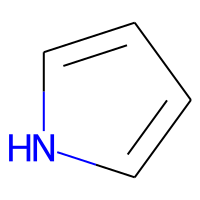
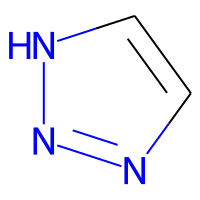
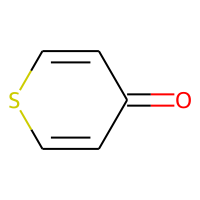
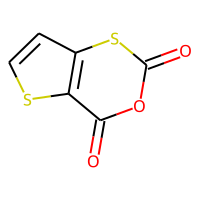
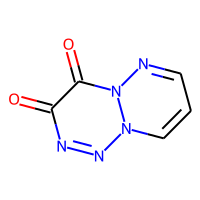
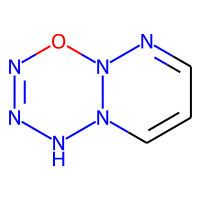
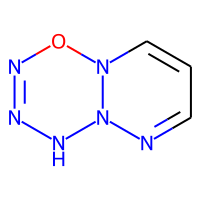
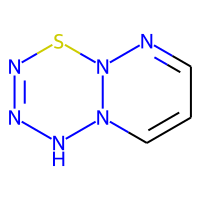
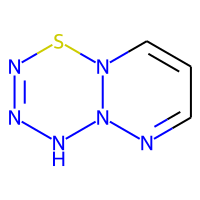
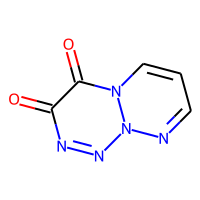

In [6]:
#vamos visualizar

PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")
molecules
#aparentemente ja sao fragmentos!


In [7]:
#calculando os descritores de cada um dos "fragmentos"

molecules["mw"] = molecules["ROMol"].apply(Descriptors.ExactMolWt) #peso molecular
molecules["n_hba"] = molecules["ROMol"].apply(Descriptors.NumHAcceptors)
molecules["n_hbd"] = molecules["ROMol"].apply(Descriptors.NumHDonors)
molecules["logp"] = molecules["ROMol"].apply(Descriptors.MolLogP)

---
# Análise exploratória dos fragmentos!

Aqui começaremos a fazer análises exploratórias dos fragmentos disponíveis.
Primeiramente, calculamos alguns descritores fundamentais como peso molecular, número de aceptores/doadores de hidrogênio e logP calculado


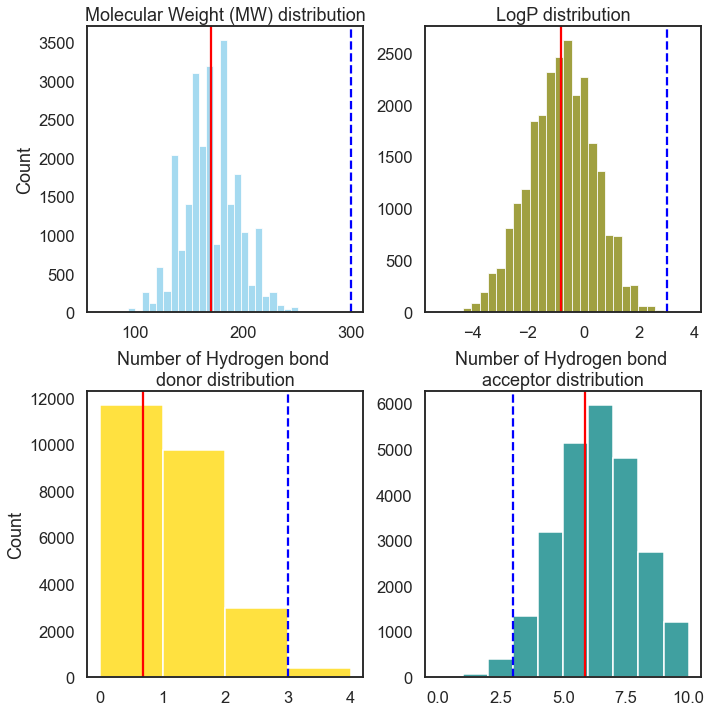

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
sns.set_context("talk")

#plot mw
fig, axs = plt.subplots(2,2, figsize = (10,10))
sns.histplot(data = molecules, x = "mw", kde = False, color = "skyblue", ax = axs[0,0], 
             bins = 30).set(title='Molecular Weight (MW) distribution', xlabel = "")
axs[0,0].axvline(molecules.mw.mean(), color = "red") 
axs[0,0].axvline(300, color = "blue", linestyle = "--") #max frag based

#plot LogP
sns.histplot(data = molecules, x = "logp", kde = False, color = "olive", ax = axs[0,1], 
             bins = 30).set(title='LogP distribution' , xlabel = "", ylabel= "")
axs[0,1].axvline(molecules.logp.mean(), color = "red")
axs[0,1].axvline(3, color = "blue", linestyle = "--") #max frag based

#plot numero de doadores de h
sns.histplot(data = molecules, x = "n_hbd", kde = False, color = "gold", ax = axs[1,0],
             binwidth = 1).set(title = "Number of Hydrogen bond \ndonor distribution", xlabel = "")
axs[1,0].axvline(molecules.n_hbd.mean(), color = "red")
axs[1,0].axvline(3, color = "blue", linestyle = "--") #max frag based


#plot numero de aceptores de h
sns.histplot(data = molecules, x = "n_hba", kde = False, color = "teal", ax = axs[1,1], 
             binwidth = 1).set(title = "Number of Hydrogen bond \nacceptor distribution", xlabel = "", ylabel= "")
axs[1,1].axvline(molecules.n_hba.mean(), color = 'red')
axs[1,1].axvline(3, color = "blue", linestyle = "--") #max frag based

fig.tight_layout()

Podemos observar que a distribuicao de peso molecular, logp, numero de aceptores de hidrogenio possuem distribuicao aproximadamente normal!

In [9]:
print(f'media mw = {molecules.mw.mean()}')
print(f'media logp = {molecules.logp.mean()}')
print(f'media hbd = {molecules.n_hbd.mean()}')
print(f'media hba = {molecules.n_hba.mean()}')

media mw = 170.0219848371731
media logp = -0.7989801351188323
media hbd = 0.6823098886073913
media hba = 5.866972292596614


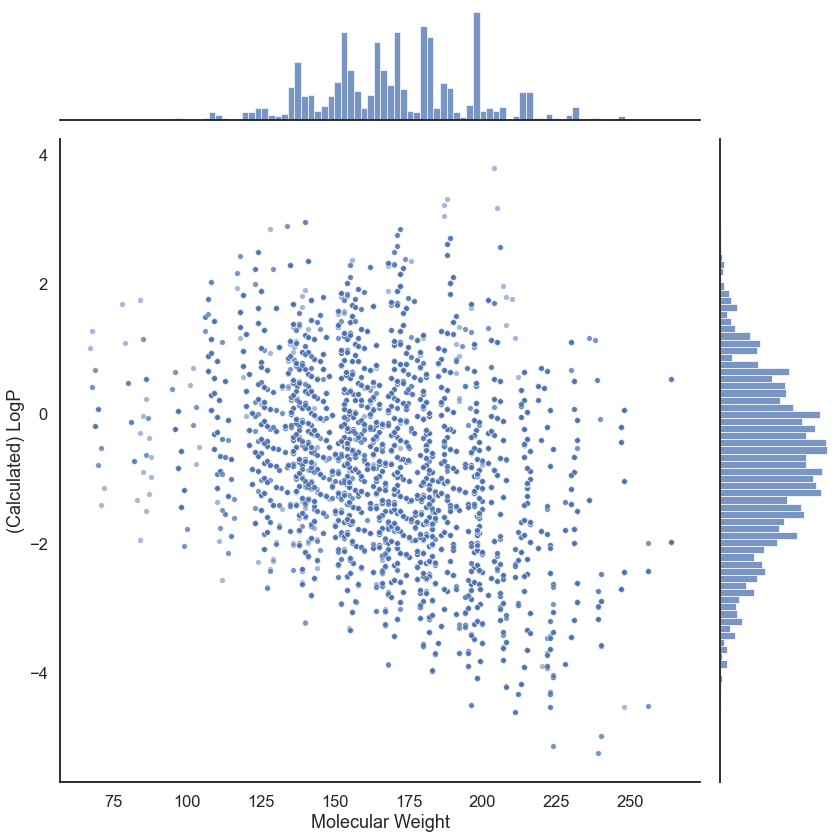

In [10]:
sns.set(style = "white")
sns.set_context("talk")

mw_logp_plt = sns.jointplot(x = "mw", y = "logp", data = molecules, 
              alpha = 0.5, height = 12, s = 30).set_axis_labels("Molecular Weight", "(Calculated) LogP")

mw_logp_plt.figure.tight_layout()

# Clustering compounds

## Calculating Fingerprints

In [11]:
#setting seed

seed_everything()  # fix seed to get deterministic outputs

In [12]:
# Create molecules from SMILES and store in array
compounds = []
# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
for _, Regid, smiles in molecules[["Regid", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), Regid))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x22e7d772040>, 'S1'),
 (<rdkit.Chem.rdchem.Mol at 0x22e1bdb9100>, 'S10'),
 (<rdkit.Chem.rdchem.Mol at 0x22e1bd5fd60>, 'S100'),
 (<rdkit.Chem.rdchem.Mol at 0x22e1bcc7e20>, 'S1000'),
 (<rdkit.Chem.rdchem.Mol at 0x22e7d78d3a0>, 'S10000')]

In [13]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))
# NBVAL_CHECK_OUTPUT

Number of compounds converted: 24867
Fingerprint length per compound: 2048


## Calculation Tanimoto Coefficient

In [14]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [15]:
# Example: Calculate single similarity of two fingerprints
# NBVAL_CHECK_OUTPUT
sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")


Tanimoto similarity: 0.14, distance: 0.86


In [16]:
# Example: Calculate distance matrix (distance = 1-similarity)
tanimoto_distance = tanimoto_distance_matrix(fingerprints)

In [17]:
# Side note: That looked like a list and not a matrix.
# But it is a triangular similarity matrix in the form of a list
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance)})",
)
# NBVAL_CHECK_OUTPUT

Elements in the triangular matrix (309171411) == tanimoto_distance_matrix(fingerprints) (309171411)


## Clustering

We will use the Butina algorithm, which clusters the molecules based on tanimoto distance. To do this, a cutoff is used, which will cluster molecules below the cutoff.

In [18]:
def cluster_fingerprints(distance_matrix, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [19]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(tanimoto_distance, cutoff=0.3)

In [20]:
# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g50 = sum(1 for c in clusters if len(c) > 50)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >50 compounds: ", num_clust_g50)
# NBVAL_CHECK_OUTPUT

total # clusters:  8630
# clusters with only 1 compound:  4234
# clusters with >5 compounds:  960
# clusters with >25 compounds:  48
# clusters with >50 compounds:  6


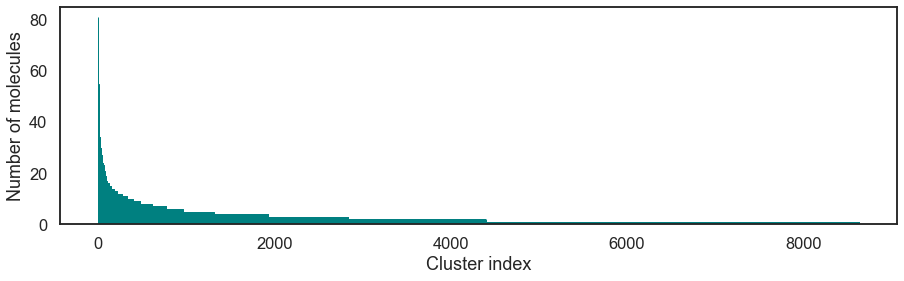

In [21]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=1, ec='teal');
plt.show()

## Searching for a reasonable cutoff

Here, we will test several different cutoff values. As the cutoff gets larger, more molecules are clustered together, and less clusters are formed.

First, we will check on a broader cutoff range, from 0.0 to 1.0. We are taking steps of 0.2.

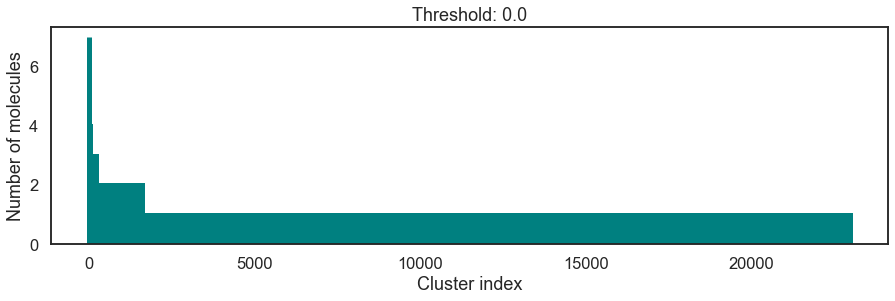

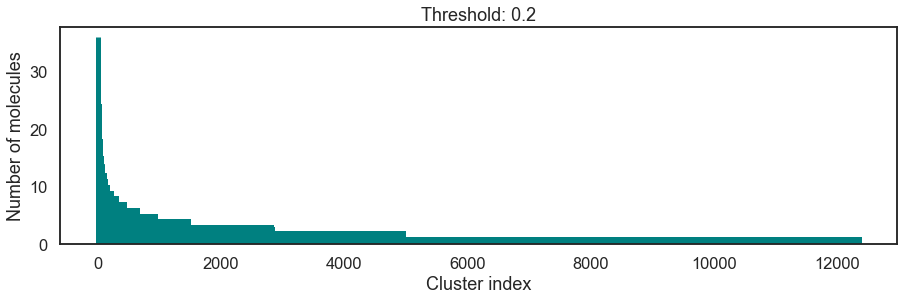

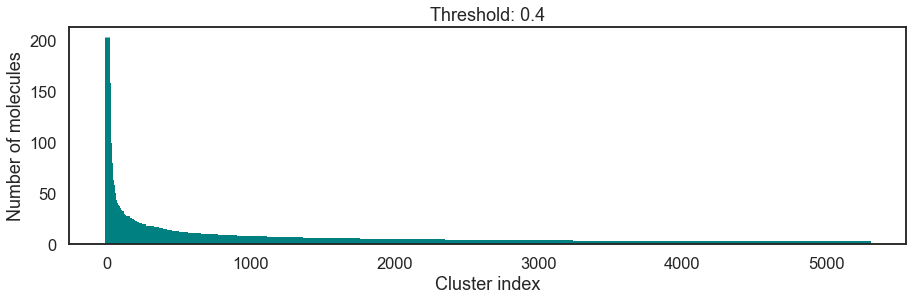

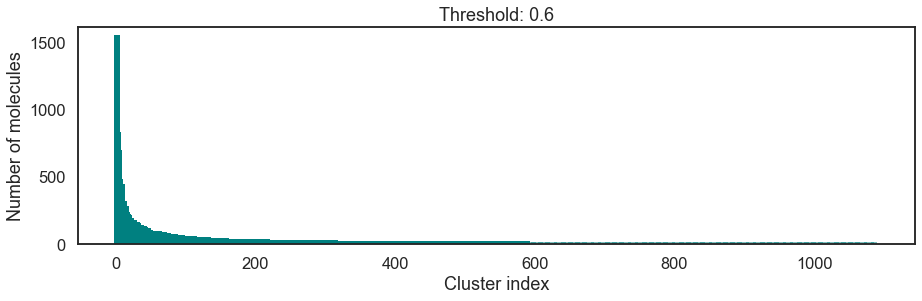

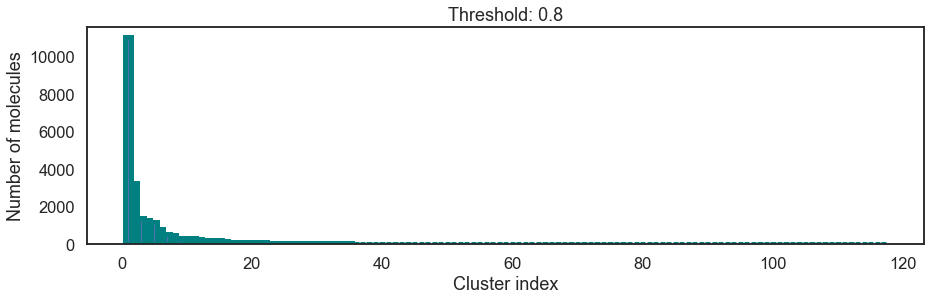

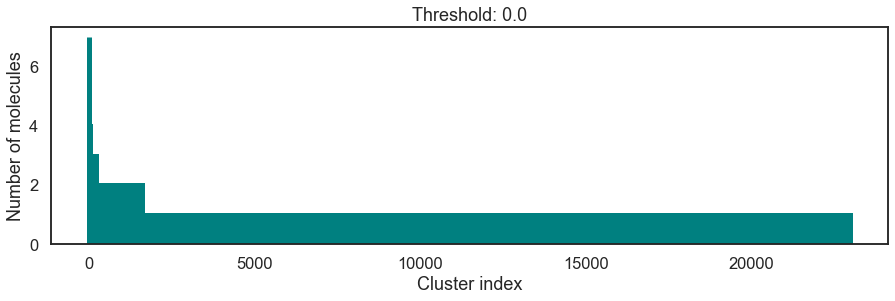

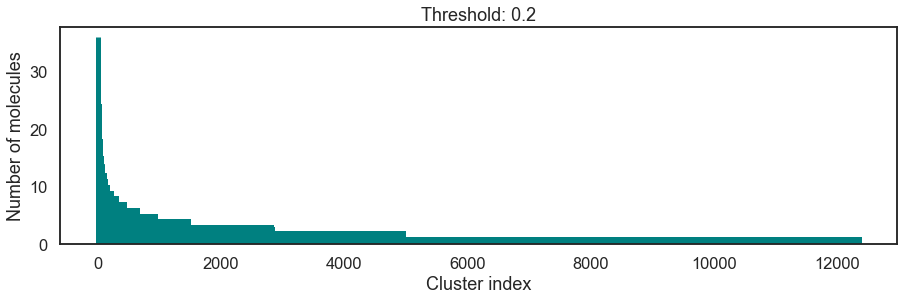

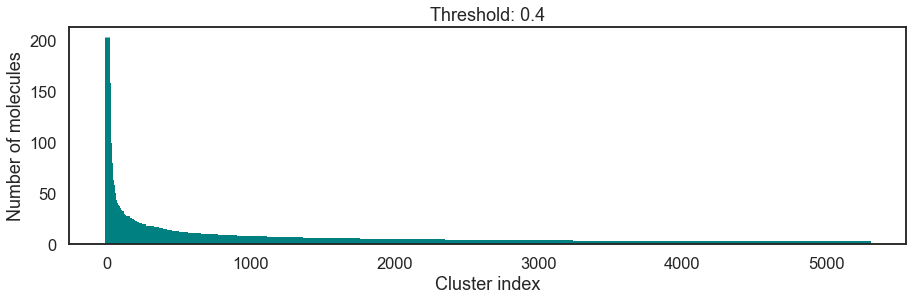

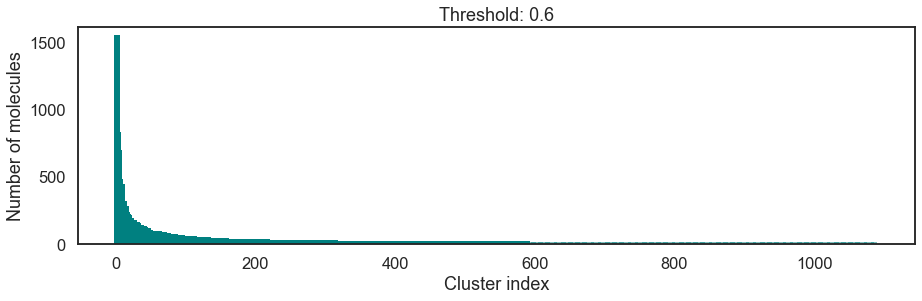

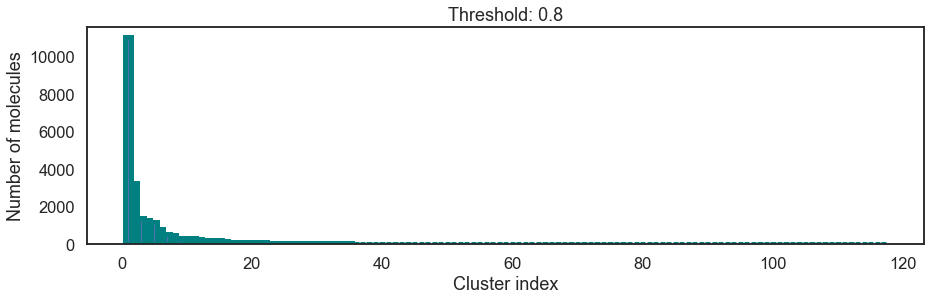

In [99]:


for cutoff in np.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(tanimoto_distance, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5, ec='teal');
    display(fig)

### In this analysis, we came to the conclusion that the clusters formed between the cutoff of 0.2 and 0.6 seem acceptable. We will analyse them further.

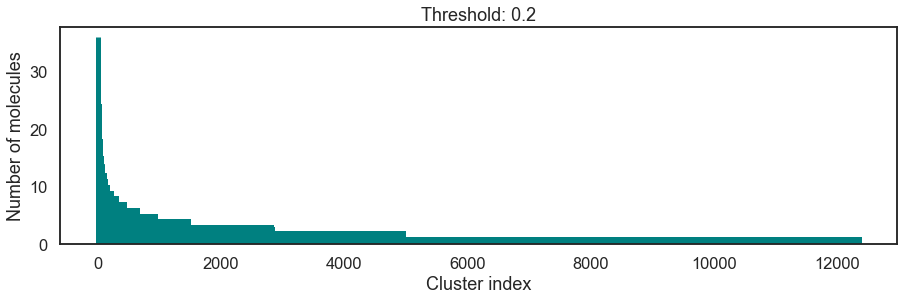

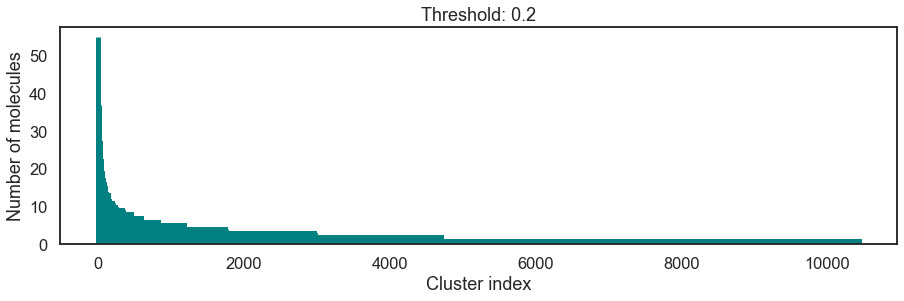

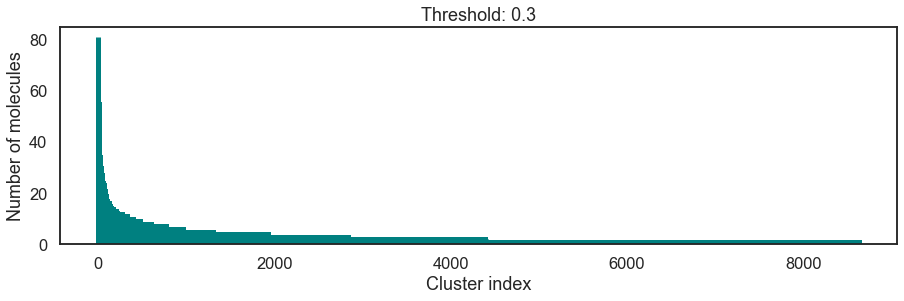

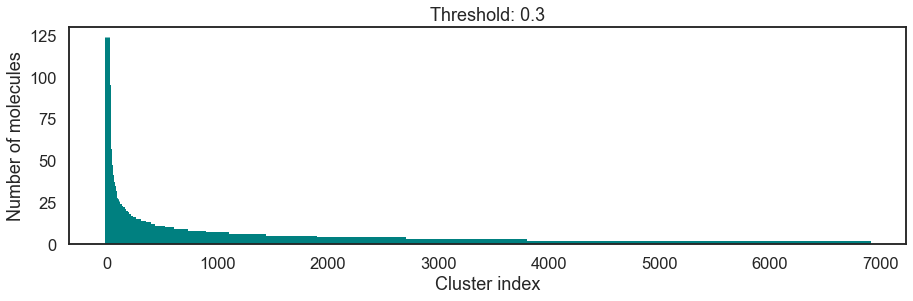

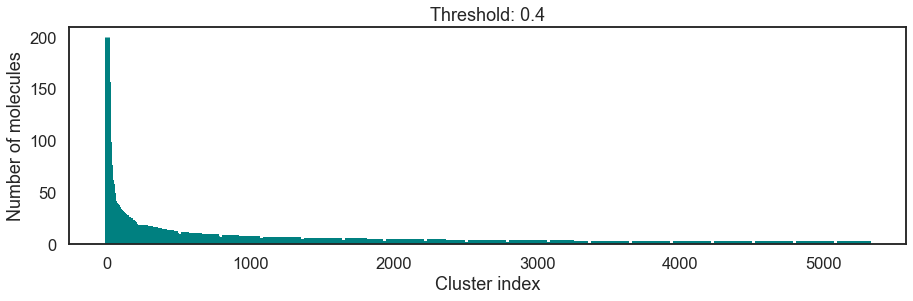

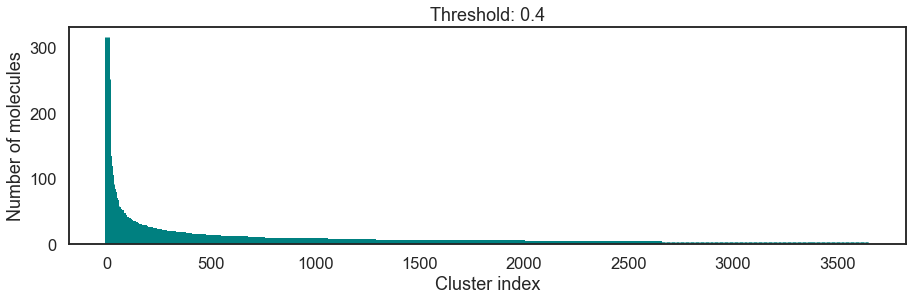

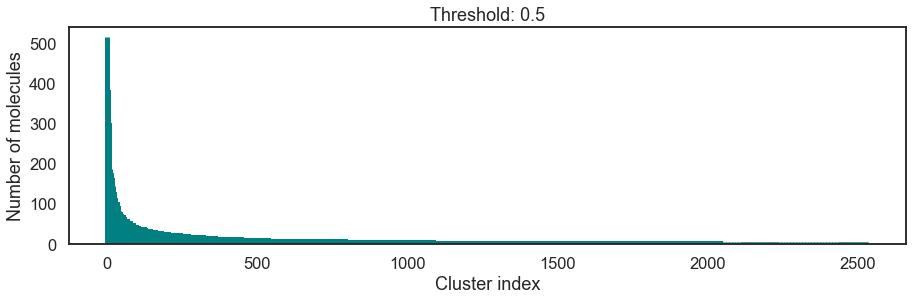

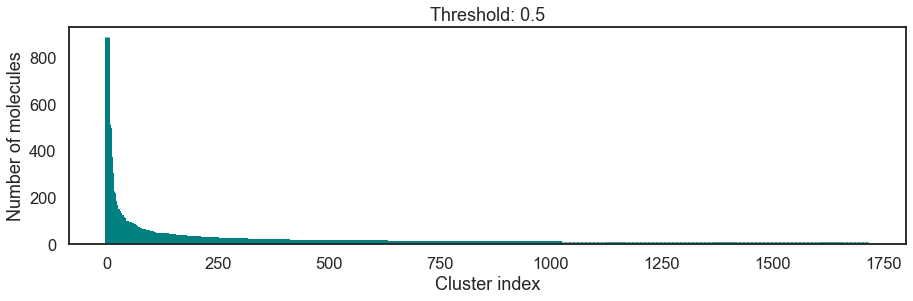

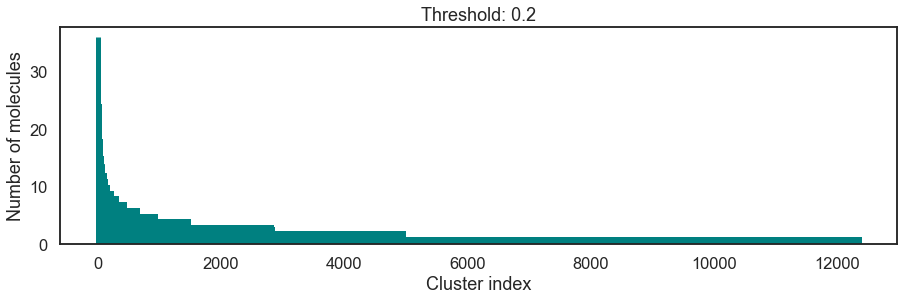

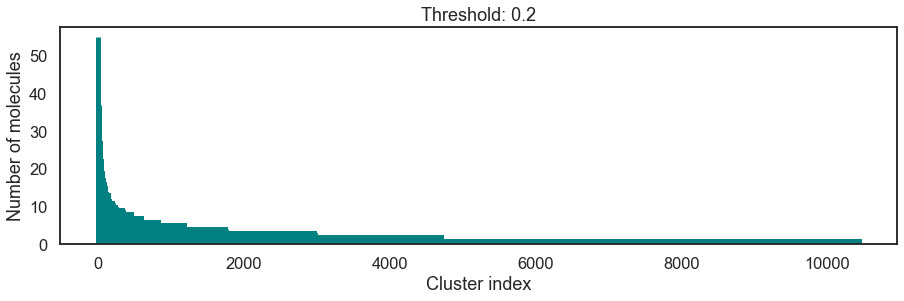

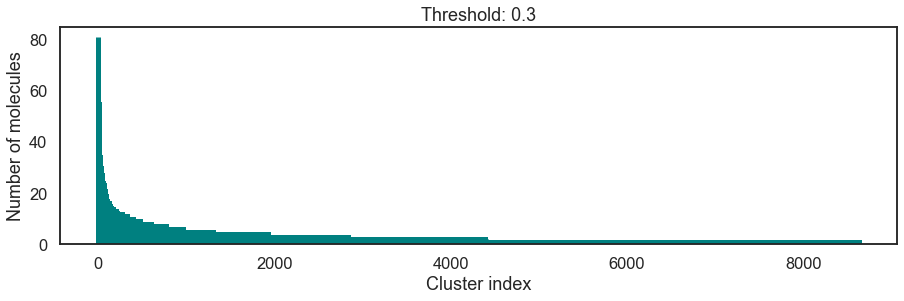

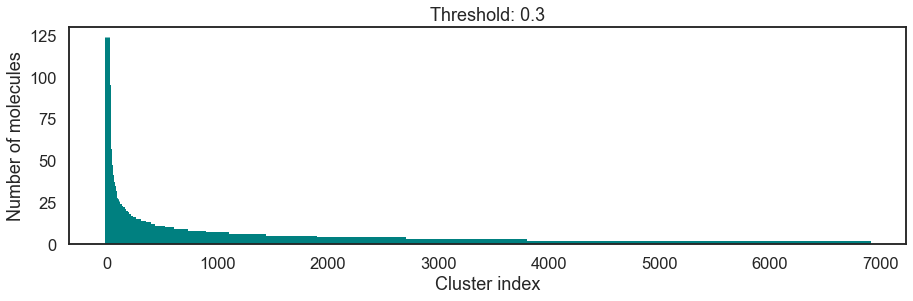

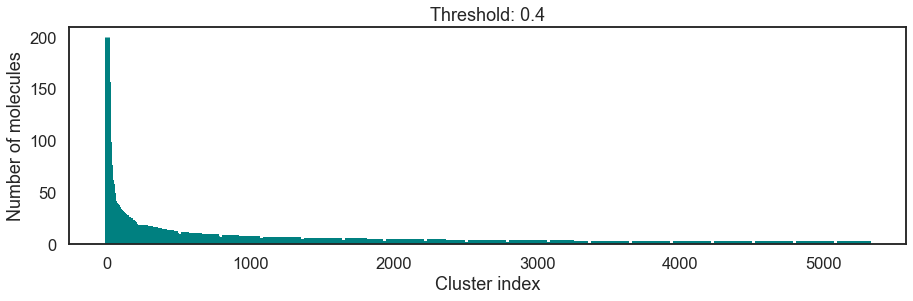

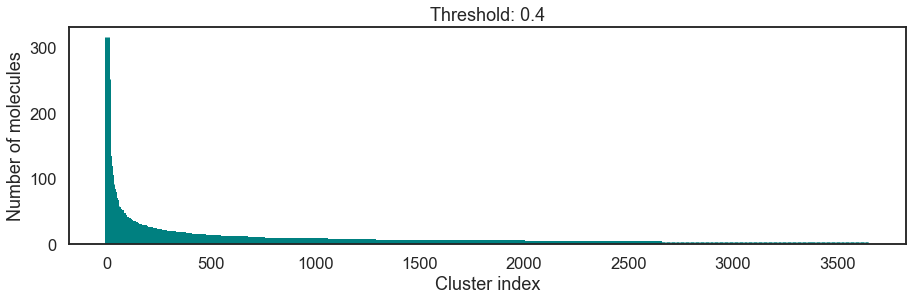

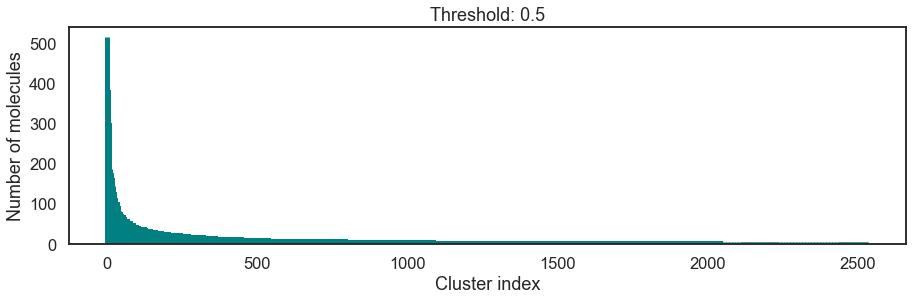

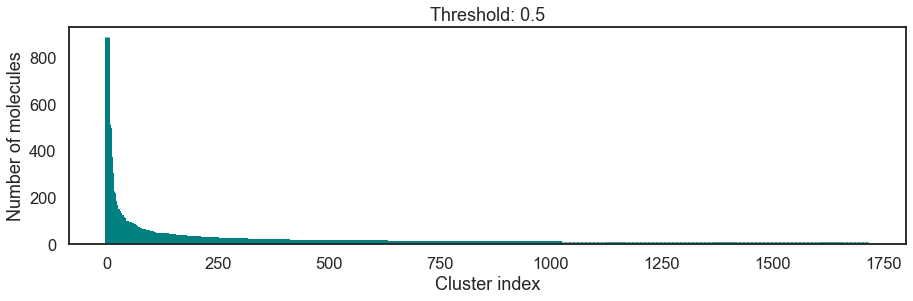

In [100]:
for cutoff in np.arange(0.2, 0.6, 0.05):
    clusters = cluster_fingerprints(tanimoto_distance, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5, ec='teal');
    display(fig)

### We chose to use the cutoff 0.4, because the number of clusters selected and their sizes seems acceptable.

Number of clusters: 5291 from 24867 molecules at distance cut-off 0.40
Number of molecules in largest cluster: 203
Similarity between two random points in same cluster: 0.76
Similarity between two random points in different cluster: 0.26


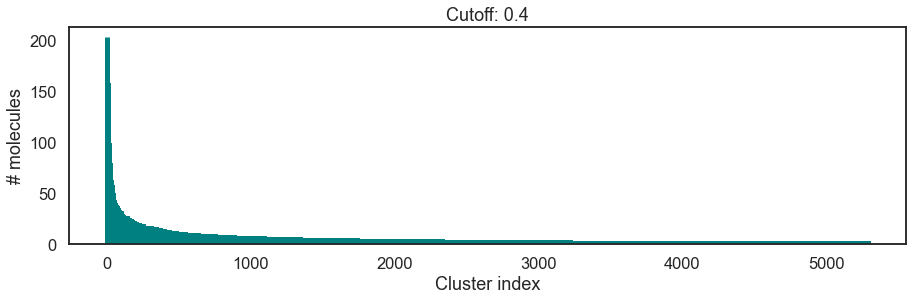

In [106]:
cutoff = 0.4
clusters = cluster_fingerprints(tanimoto_distance, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5, ec='teal')
ax.set_title(f"Cutoff: {cutoff:3.1f}")
fig.savefig(
    DATA / f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

# Visualizing the clusters

Ten molecules from largest cluster:


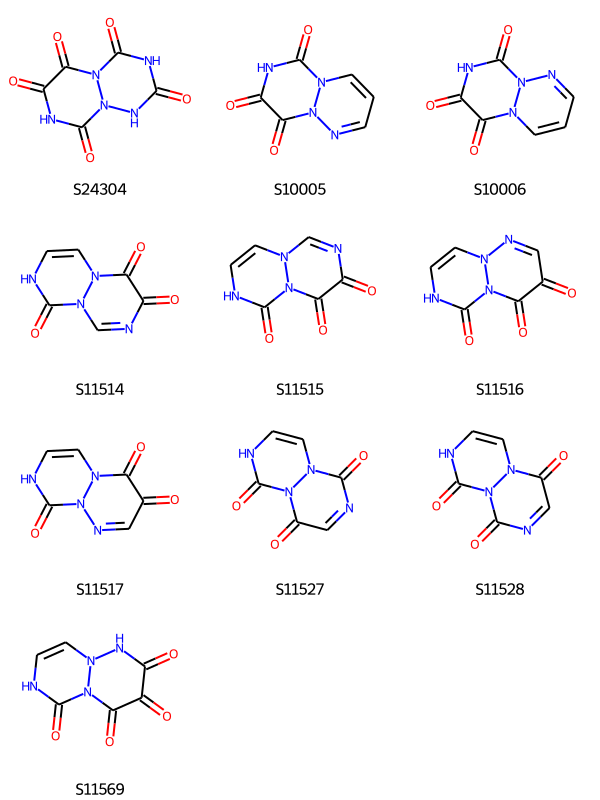

In [167]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:10]],
    legends=[compounds[i][1] for i in clusters[0][:10]],
)

In [168]:
# Save molecules from largest cluster
sdf_path = str(DATA / "molecule_set_largest_cluster.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters[0]:
    mol, label = compounds[index]
    # Add label to metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)
sdf.close()

Ten molecules from second largest cluster:


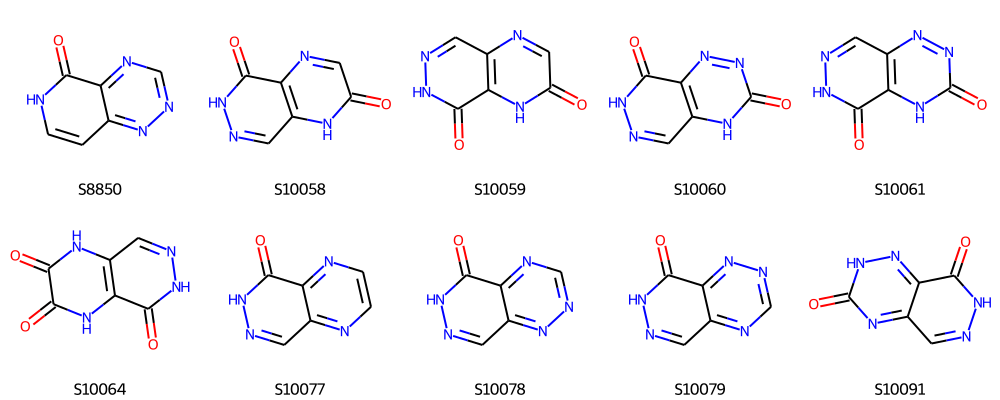

In [169]:
print("Ten molecules from second largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[1][:10]],
    legends=[compounds[i][1] for i in clusters[1][:10]],
    molsPerRow=5,
)

Ten molecules from second largest cluster:


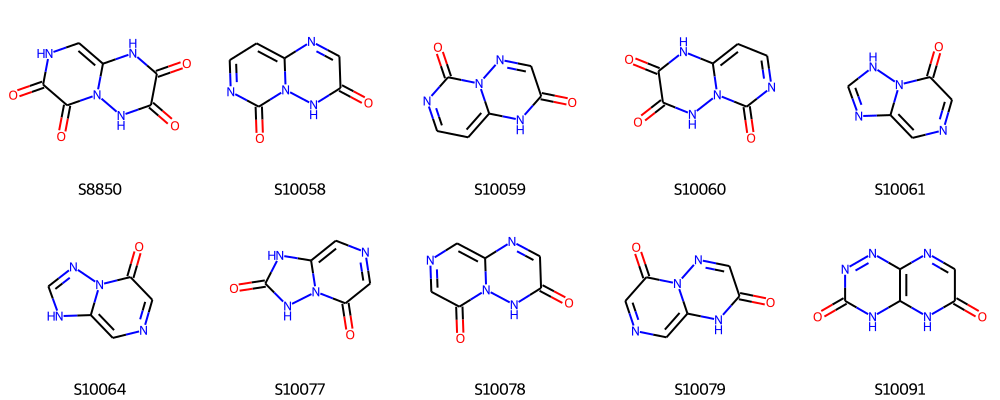

In [173]:
print("Ten molecules from second largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[2][:10]],
    legends=[compounds[i][1] for i in clusters[1][:10]],
    molsPerRow=5,
)

Ten molecules from first 10 clusters:


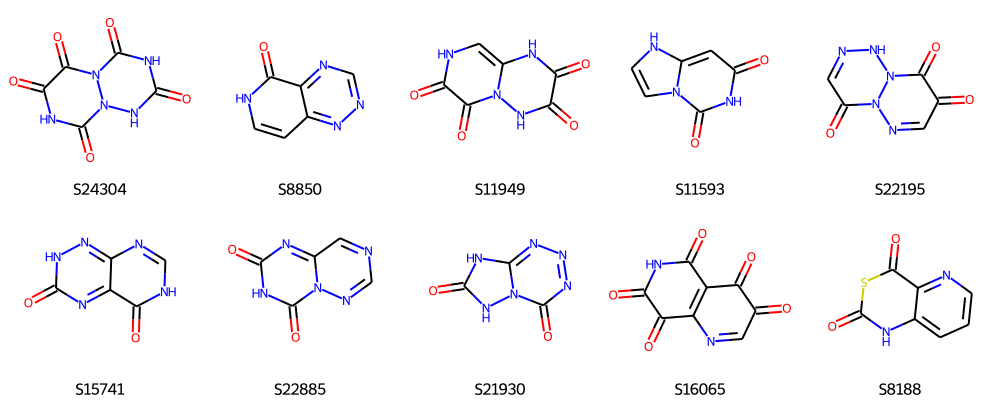

In [174]:
print("Ten molecules from first 10 clusters:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(10)],
    legends=[compounds[clusters[i][0]][1] for i in range(10)],
    molsPerRow=5,
)

## Intra-cluster Tanimoto similarities

In [180]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [181]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

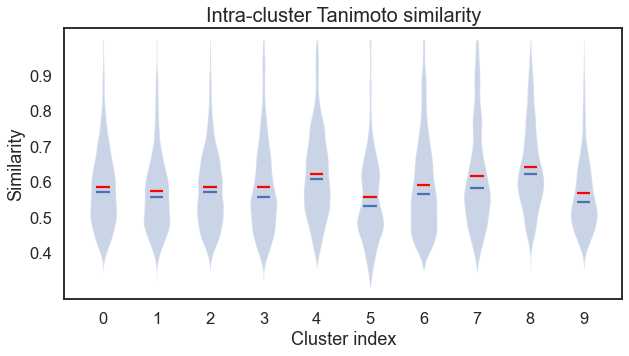

In [187]:
# Violin plot with intra-cluster similarity

fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(numpy.arange(0.4, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=20)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue